# Final Project

## Do people name their children after Game of Thrones characters?

#### Setting up the notebook
First, import libraries and set up jupyter magic for matplotlib and gcloud bigquery

In [23]:
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split

%matplotlib inline
%reload_ext google.cloud.bigquery

#### Establishing BiqQuery Credentials and Environment

In [24]:
credentials = service_account.Credentials.from_service_account_file('keys/names_proj_key.json')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="keys/names_proj_key.json"
client = bigquery.Client(credentials=credentials, project='628610721')

#### Set query for USA names dataset to a dateframe (post-1970 names)

In [26]:
df = client.query('''
    SELECT name
    , gender
    , year
    , sum(number) as number
    FROM
        `bigquery-public-data.usa_names.usa_1910_current`
    WHERE
        year > 1960
    GROUP BY name, year, gender
    ORDER BY name, year
''').to_dataframe()

In [27]:
df.head()

,name,gender,year,number
0,Aaban,M,2013,6
1,Aaban,M,2014,6
2,Aadan,M,2008,12
3,Aadan,M,2009,6
4,Aadan,M,2014,5


In [28]:
df.tail()

,name,gender,year,number
25938,Zyriah,F,2013,7
25939,Zyriah,F,2014,6
25940,Zyriah,F,2016,5
25941,Zyron,M,2015,5
25942,Zyshonne,M,1998,5


In [29]:
df.shape

(425943, 4)

In [30]:
df.dtypes

name      object
gender    object
year       int64
number     int64
dtype: object

### Data Dictionary
#### Movie/TV Show relevance:
- 0: Not a relevant year
- 1-n: 1 - nth year(s) of popularity
#### Character type:
- 0: None
- 1: Supporting
- 2: Lead
#### Create several lists: one for all character names being evaluated, one for each show/movie, one each for lead and supporting roles of character being evaluated 

In [31]:
got = ['Ned','Robert','Jaime','Catelyn','Cersei','Daenerys','Jorah','Viserys','Jon','Sansa','Arya','Robb','Theon','Bran','Joffrey','Sandor','Tyrion','Khal','Petyr','Davos','Samwell','Stannis','Melisandre','Jeor','Bronn','Verys','Varys','Shae','Margaery','Tywin','Talisa','Ygritte','Gendry','Tormund','Brienne','Ramsay','Gilly','Daario','Missandrei','Ellaria','Tommen','Jaqen','Roose','Khaleesi']

#### Create a new column to quantify the popularity of character names during the years of the individual show/movie relevance

In [32]:
got = ['Khaleesi','Daenerys','Jaime','Jon','Arya','Tyrion','Sansa']

In [33]:
def khaleesi(row):
    if row['name']=='Khaleesi':
        return row['number']
    else:
        return 0
    
df['khal'] = df.apply(lambda row: khaleesi(row), axis=1)

def daenerys(row):
    if row['name']=='Daenerys':
        return row['number']
    else:
        return 0
    
df['dani'] = df.apply(lambda row: daenerys(row), axis=1)

def jon(row):
    if row['name']=='Jon':
        return row['number']
    else:
        return 0
    
df['jon'] = df.apply(lambda row: jon(row), axis=1)

def tyr(row):
    if row['name']=='Tyrion':
        return row['number']
    else:
        return 0
    
df['tyr'] = df.apply(lambda row: tyr(row), axis=1)

def arya(row):
    if row['name']=='Arya':
        return row['number']
    else:
        return 0
    
df['arya'] = df.apply(lambda row: arya(row), axis=1)

def sansa(row):
    if row['name']=='Sansa':
        return row['number']
    else:
        return 0
    
df['sansa'] = df.apply(lambda row: sansa(row), axis=1)

def jaime(row):
    if row['name']=='Jaime':
        return row['number']
    else:
        return 0
    
df['jaime'] = df.apply(lambda row: jaime(row), axis=1)

#### Create a column to show trend of all main characters

In [34]:
def all_main(row):
    if (row['name'] in (got)):
        return row['number']
    else:
        return 0
    
df['all_main'] = df.apply(lambda row: all_main(row), axis=1)

#### Create a column to show popular years of GoT

In [35]:
def origin(row):
    if (2011 <= row['year'] <= 2018):
        return 1
    else:
        return 0
df['got_rel'] = df.apply(lambda row: origin(row), axis=1)

#### Create a column to show the first estimation of relevance (Nielsen ratings by season/year)

In [36]:
def got_pop_year(row):
    if row['name'] in (got) and (row['year']==2011):
        return 2.52
    elif row['name'] in (got) and (row['year']==2012):
        return 3.80
    elif row['name'] in (got) and (row['year']==2013):
        return 4.97
    elif row['name'] in (got) and (row['year']==2014):
        return 6.84
    elif row['name'] in (got) and (row['year']==2015):
        return 6.88
    elif row['name'] in (got) and (row['year']==2016):
        return 7.69
    elif row['name'] in (got) and (row['year']==2017):
        return 10.26
    else:
        return 0
df['nielsen'] = df.apply(lambda row: got_pop_year(row), axis=1)

#### Create a column to show the second estimation of relevance (1 for popular year, 0 for not popular)

In [37]:
def got_pop_year(row):
    if row['name'] in (got) and (2011<= row['year'] <= 2018):
        return 1
    else:
        return 0
df['got_years'] = df.apply(lambda row: got_pop_year(row), axis=1)

#### Create a column to show the third estimation of relevance (+1 for each increasing new year of relevance)

In [38]:
def got_pop(row):
    if (row['year']==2011):
        return 1
    elif (row['year']==2012):
        return 2
    elif (row['year']==2013):
        return 3
    elif (row['year']==2014):
        return 4
    elif (row['year']==2015):
        return 5
    elif (row['year']==2016):
        return 6
    elif (row['year']==2017):
        return 7
    else:
        return 0
    
df['got_pop'] = df.apply(lambda row: got_pop_year(row), axis=1)

#### Create a new column that translates gender values to binary

In [39]:
def new_gend(row):
    if row['gender'] == 'M':
        return 0
    elif row['gender'] == 'F':
        return 1
    else:
        return NaN

df['new_gender'] = df.apply(lambda row: new_gend(row), axis=1)

#### Check for nulls

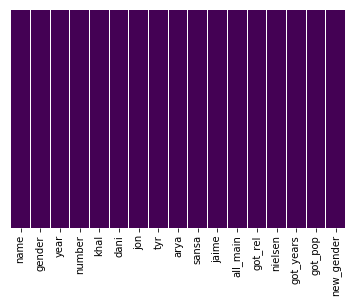

In [40]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

#### EDA: Create a function that visualizes character name popularity to get an idea of which names become popular and when

In [41]:
def plot_yearly_count(character_name):
    data_agg=df[df["name"]==character_name].groupby(["year"],as_index=False).agg({"number": "sum"})
    if len(data_agg)==0:
        print('(Un)fortunately, there is no data for the name '+str(character_name)+' at this time')
    else:
        year_df=pd.DataFrame()
        year_df["year"]=df["year"].unique()
        data_agg["key"]=1
        data_agg=pd.merge(year_df,data_agg,on=["year"],how="left")
        data_agg=data_agg.sort_values("year",ascending=True)
        ax=data_agg.plot('year', 'number', kind='bar', figsize=(15,4), color='#afeeee', zorder=2, width=0.75)
        # Switch off ticks
        ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)
        # Set x-axis label
        ax.set_xlabel("Year", labelpad=20, size=12)
        # Set y-axis label
        ax.set_ylabel("# of Occurrences", labelpad=20, size=12)
        # Set title
        ax.set_title("Popularity of the name "+str(character_name)+" since 1970")
        ax.legend_.remove()

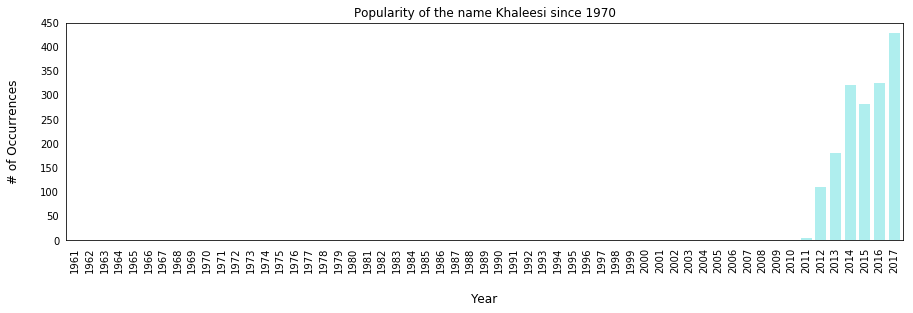

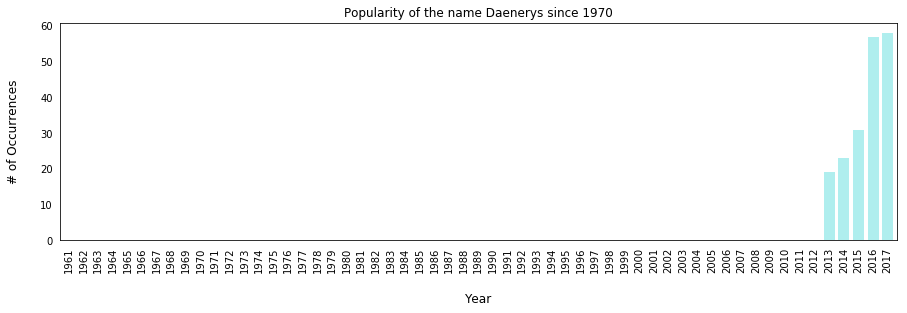

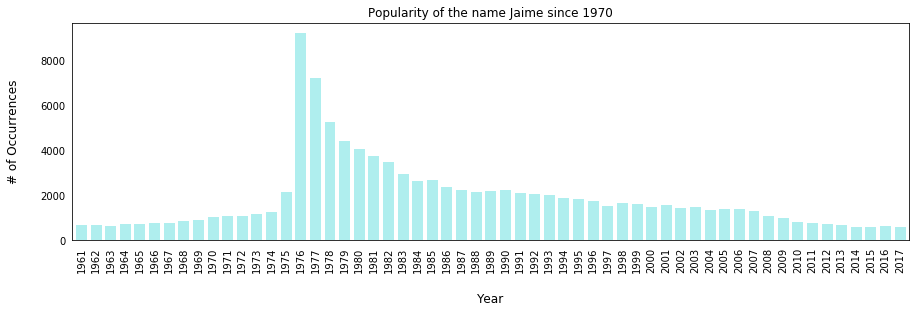

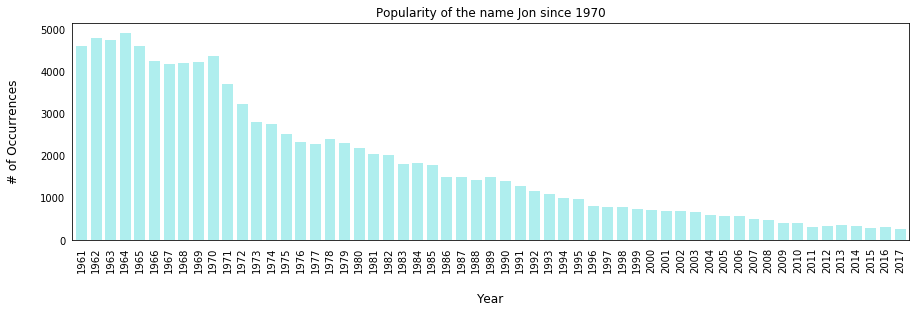

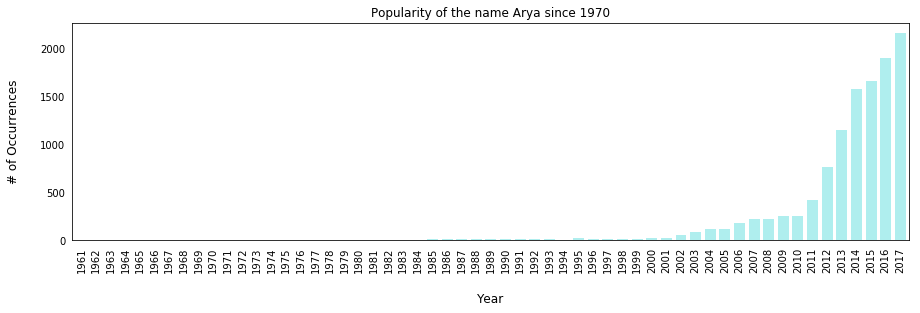

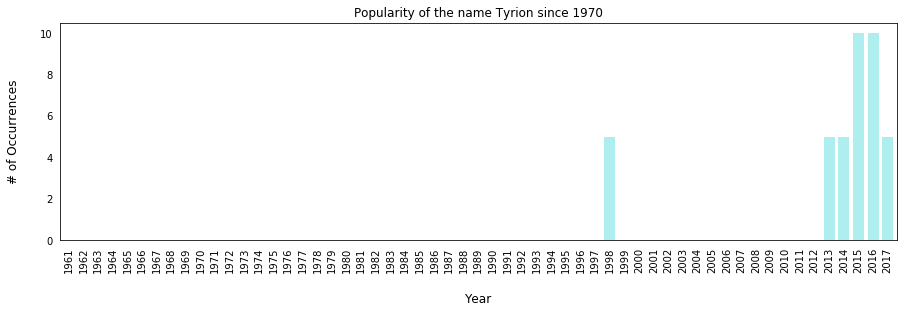

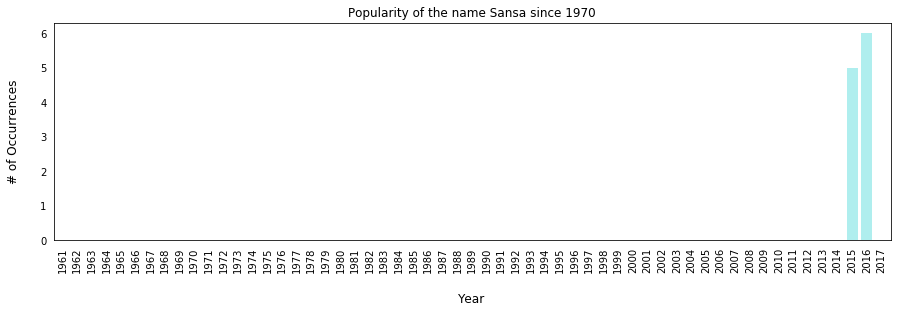

In [42]:
for n in got:
    plot_yearly_count(n)

#### Describe dataframe

In [43]:
df.describe()

,year,number,khal,dani,jon,tyr,arya,sansa,jaime,all_main,got_rel,nielsen,got_years,got_pop,new_gender
count,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000,425943.000000
mean,1993.613094,432.317456,0.003871,0.000441,0.247446,0.000094,0.026806,0.000026,0.250217,0.528902,0.164956,0.000811,0.000127,0.000127,0.580183
std,15.656094,2240.917944,1.099251,0.140965,27.231753,0.026539,5.985923,0.011967,22.896664,36.093362,0.371142,0.076562,0.011259,0.011259,0.493529
min,1961.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1982.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1996.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2007.000000,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2017.000000,86922.000000,428.000000,58.000000,4904.000000,10.000000,2146.000000,6.000000,7836.000000,7836.000000,1.000000,10.260000,1.000000,1.000000,1.000000


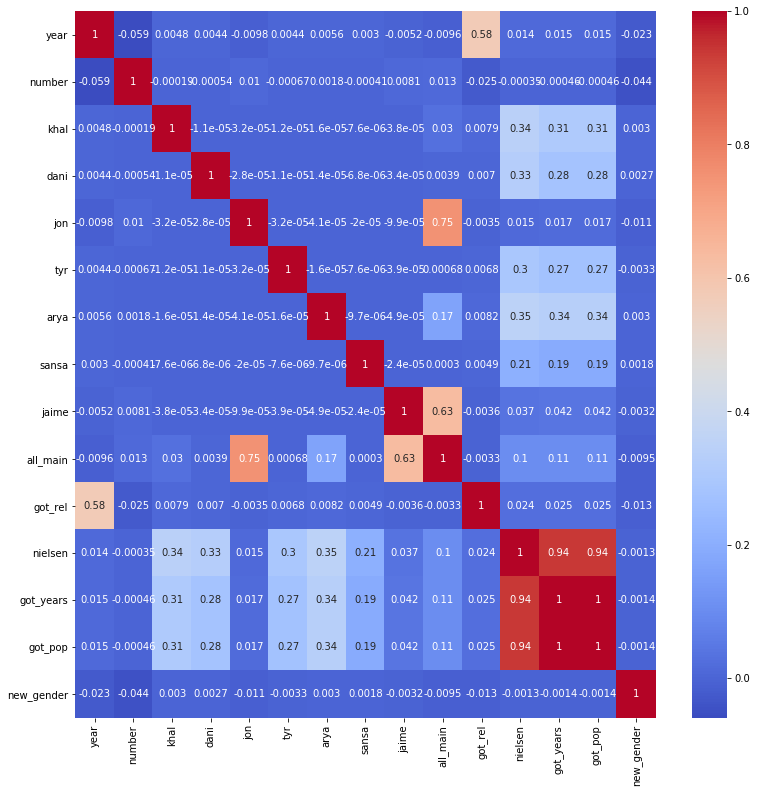

In [44]:
plt.subplots(figsize=(13,13))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

#### It looks like Khaleesi, Arya, Tyrion, Daenerys, and Sansa are the highest correlated with Nielsen ratings, so let's look at these in a pairplot

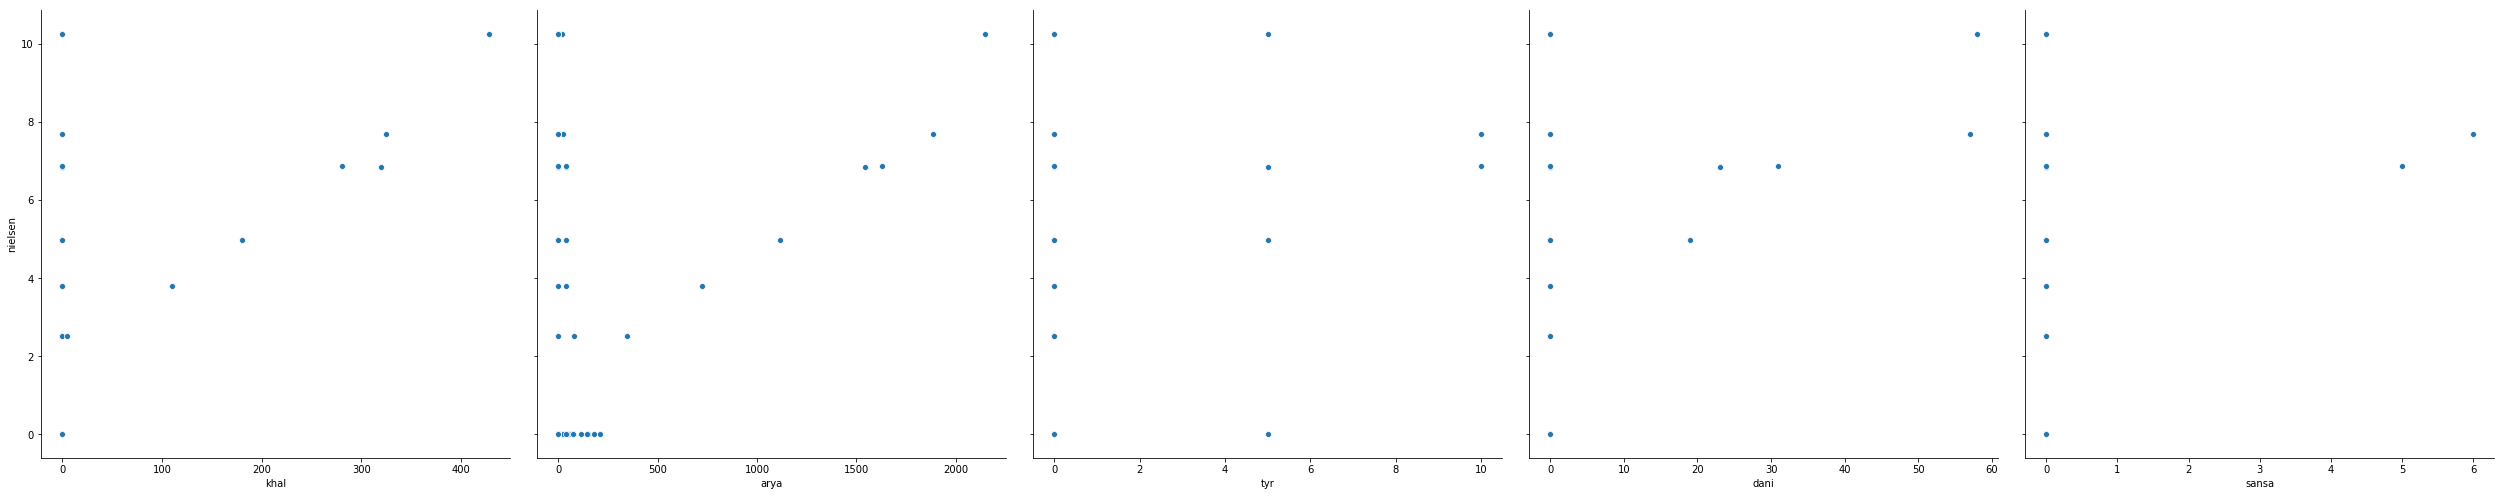

In [45]:
sns.pairplot(df,y_vars=['nielsen'],x_vars=['khal','arya','tyr','dani','sansa'],height=7)

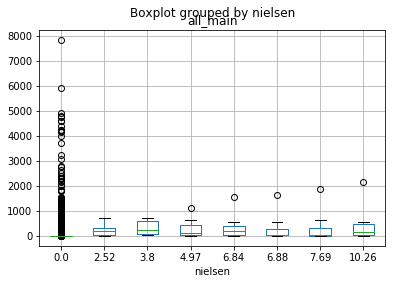

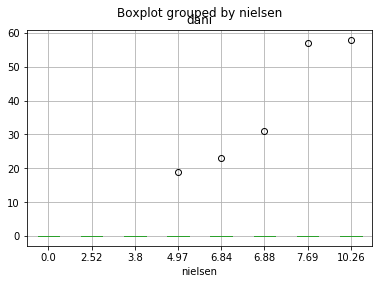

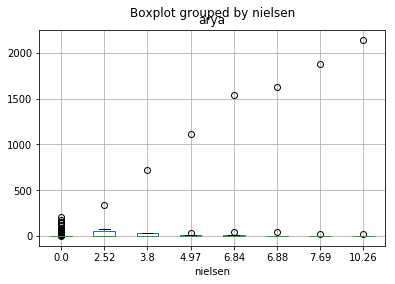

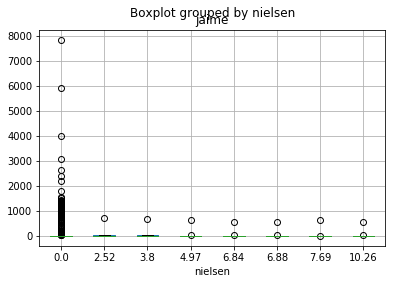

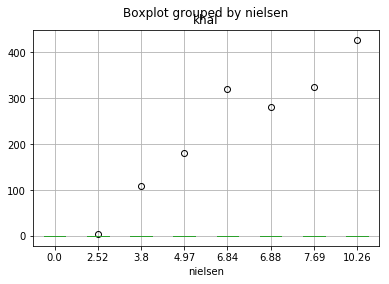

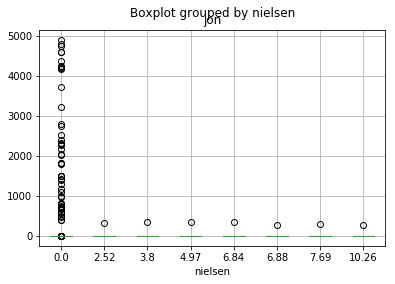

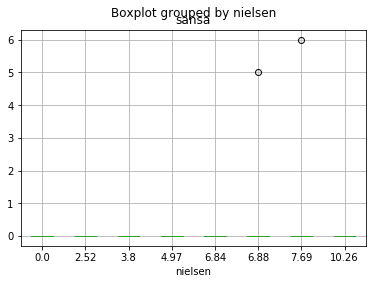

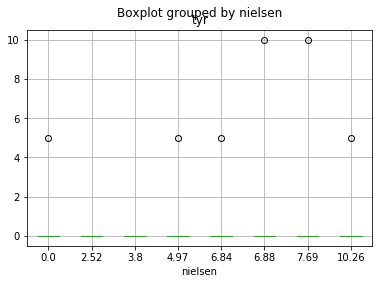

In [46]:
df.boxplot(column='all_main', by='nielsen');
df.boxplot(column='dani', by='nielsen');
df.boxplot(column='arya', by='nielsen');
df.boxplot(column='jaime', by='nielsen');
df.boxplot(column='khal', by='nielsen');
df.boxplot(column='jon', by='nielsen');
df.boxplot(column='sansa', by='nielsen');
df.boxplot(column='tyr', by='nielsen');

#### Maybe not Sansa. Let's do Khaleesi, Daenerys, Tyrion, and Arya

## Start the model

## Start with Khaleesi
#### Set feature columns: Nielsen rating against number

In [47]:
feature_cols = ['nielsen']
X = df[feature_cols]
y = df.khal

#### Check values and shapes

In [48]:
print((type(X)))
print((type(X.values)))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [49]:
X.shape

(425943, 1)

In [50]:
y.shape

(425943,)

#### Instantiate, fit, predict, and score. Then do a train-test-split

In [51]:
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

In [52]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
dict(zip(lr.coef_,X.columns))

{4.941053136804542: 'nielsen'}

In [54]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
lr.predict(np.array([0]).reshape(1,-1))

array([-0.00013776])

In [55]:
X_new = [[1], [11]]
lr.predict(X_new)

array([ 4.94091538, 54.35144675])

In [56]:
# Print the coefficients.
print(lr.intercept_)
print(lr.coef_)

-0.00013775874849690593
[4.94105314]


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [58]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [59]:
#Predict
y_pred = lr.predict(X_test)

In [60]:
#Score
print('MSE: ', metrics.mean_squared_error(y_train, lr.predict(X_train)))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MSE:  1.057483118145229
RMSE:  1.047328255656612


In [61]:
lr = LinearRegression()

parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr,parameters, cv=10)
grid.fit(X_train, y_train)
print ("best r2: ", grid.best_score_)
print("Testing RMSE: %.2f"
              % (np.sqrt(metrics.mean_squared_error(y_test, grid.predict(X_test)))))
print("Testing MAE: %.2f"
              % ((metrics.mean_absolute_error(y_test, grid.predict(X_test)))))

best r2:  0.03863141244932628
Testing RMSE: 1.05
Testing MAE: 0.01


## Trying Daenerys now

#### Instantiate, fit, predict, and score. Then do a train-test-split

In [62]:
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

In [63]:
feature_cols = ['nielsen']
X = df[feature_cols]
y = df.dani

In [64]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [65]:
dict(zip(lr.coef_,X.columns))

{0.6001000883713788: 'nielsen'}

In [66]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
lr.predict(np.array([0]).reshape(1,-1))

array([-4.55473891e-05])

In [67]:
X_new = [[1], [11]]
lr.predict(X_new)

array([0.60005454, 6.60105542])

In [68]:
# Print the coefficients.
print(lr.intercept_)
print(lr.coef_)

-4.5547389068565996e-05
[0.60010009]


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [70]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [71]:
#Predict
y_pred = lr.predict(X_test)

In [72]:
#Score
print('MSE: ', metrics.mean_squared_error(y_train, lr.predict(X_train)))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MSE:  0.023081509330798798
RMSE:  0.04666831601043868


In [73]:
lr = LinearRegression()

parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr,parameters, cv=10)
grid.fit(X_train, y_train)
print ("best r2: ", grid.best_score_)
print("Testing RMSE: %.2f"
              % (np.sqrt(metrics.mean_squared_error(y_test, grid.predict(X_test)))))
print("Testing MAE: %.2f"
              % ((metrics.mean_absolute_error(y_test, grid.predict(X_test)))))

best r2:  0.033863629841664224
Testing RMSE: 0.05
Testing MAE: 0.00


## Tyrion

#### Instantiate, fit, predict, and score. Then do a train-test-split

In [74]:
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

In [75]:
feature_cols = ['nielsen']
X = df[feature_cols]
y = df.tyr

In [76]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [77]:
dict(zip(lr.coef_,X.columns))

{0.10254117131080705: 'nielsen'}

In [78]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
lr.predict(np.array([0]).reshape(1,-1))

array([1.07074087e-05])

In [79]:
X_new = [[1], [11]]
lr.predict(X_new)

array([0.10255188, 1.12796359])

In [80]:
# Print the coefficients.
print(lr.intercept_)
print(lr.coef_)

1.0707408698515953e-05
[0.10254117]


## Trying Arya now

#### Instantiate, fit, predict, and score. Then do a train-test-split

In [81]:
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

In [82]:
feature_cols = ['nielsen']
X = df[feature_cols]
y = df.arya

In [83]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [84]:
dict(zip(lr.coef_,X.columns))

{27.58158692109246: 'nielsen'}

In [85]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
lr.predict(np.array([0]).reshape(1,-1))

array([0.00442671])

In [86]:
X_new = [[1], [11]]
lr.predict(X_new)

array([ 27.58601363, 303.40188285])

In [87]:
# Print the coefficients.
print(lr.intercept_)
print(lr.coef_)

0.0044267137720334325
[27.58158692]


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [89]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [90]:
#Predict
y_pred = lr.predict(X_test)

In [91]:
#Score
print('MSE: ', metrics.mean_squared_error(y_train, lr.predict(X_train)))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MSE:  34.380407355353185
RMSE:  4.727384261287203


In [92]:
lr = LinearRegression()

parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr,parameters, cv=10)
grid.fit(X_train, y_train)
print ("best r2: ", grid.best_score_)
print("Testing RMSE: %.2f"
              % (np.sqrt(metrics.mean_squared_error(y_test, grid.predict(X_test)))))
print("Testing MAE: %.2f"
              % ((metrics.mean_absolute_error(y_test, grid.predict(X_test)))))

best r2:  -52.6558192351157
Testing RMSE: 4.73
Testing MAE: 0.03


In [93]:
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['font.size'] = 11
plt.style.use("fivethirtyeight")

## Trying Khaleesi now

#### Instantiate, fit, predict, score. Then do a train-test-split

In [94]:
feature_cols = ['nielsen']
X = df[feature_cols]
y = df.khal

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [96]:
lr = LinearRegression()

parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr,parameters, cv=10)
grid.fit(X_train, y_train)
print ("best r2: ", grid.best_score_)
print("Testing RMSE: %.2f"
              % (np.sqrt(metrics.mean_squared_error(y_test, grid.predict(X_test)))))
print("Testing MAE: %.2f"
              % ((metrics.mean_absolute_error(y_test, grid.predict(X_test)))))

best r2:  0.03863141244932628
Testing RMSE: 1.05
Testing MAE: 0.01


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


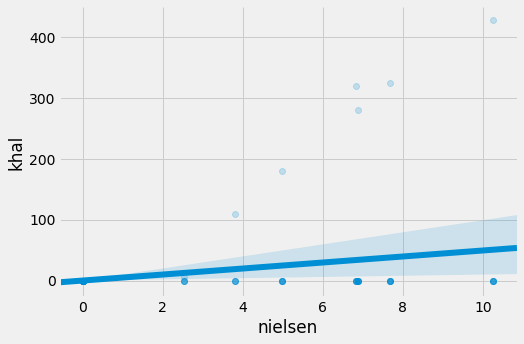

In [97]:
sns.lmplot(x='nielsen', y='khal', data=df, aspect=1.5, scatter_kws={'alpha':0.2});

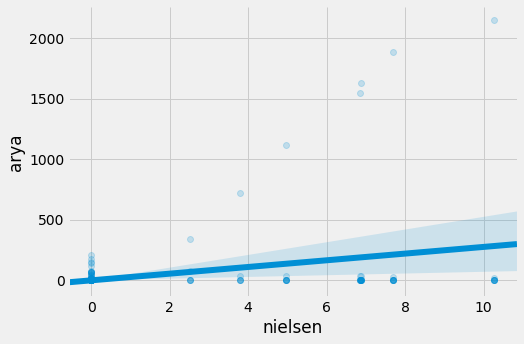

In [98]:
sns.lmplot(x='nielsen', y='arya', data=df, aspect=1.5, scatter_kws={'alpha':0.2});

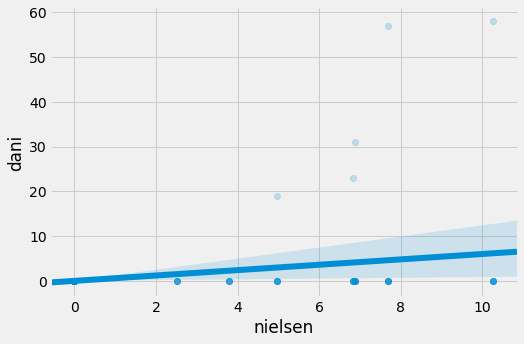

In [99]:
sns.lmplot(x='nielsen', y='dani', data=df, aspect=1.5, scatter_kws={'alpha':0.2});

In [100]:
kf = model_selection.KFold(n_splits=5, shuffle=True)

In [101]:
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.1608780792407968
R2: 0.1141971859411679

Model 2
MSE: 1.0886315291149913
R2: 0.11841629558072397

Model 3
MSE: 0.9783534741854202
R2: 0.1129130958139305

Model 4
MSE: 3.342803565545405
R2: 0.08724680083150758

Model 5
MSE: 0.22384451654450888
R2: 0.1162842996922594

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1.1589022329262244
Mean of R2 for all folds: 0.10981153557191788


In [102]:
# Note the results will vary each run since we take a different
#   subset of the data each time (since shuffle=True)
kf = model_selection.KFold(n_splits=5, shuffle=True)

print(np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(lr, X, y, cv=kf)))

1.1293418127889576
0.08778501430893718


In [103]:
#Based on this, re-run the Logistic Regression with the best features.
X = df[['nielsen']]
y = df.tyr

lr.predict(np.array([0]).reshape(1,-1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 41)

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [104]:
LogReg.score(X_test, y_test)

0.9999843484657583

In [105]:
pred = LogReg.predict_proba(X_test)[:,1]
confusion_matrix(y_test, pred > .70)

array([[127781,      0],
       [     2,      0]])

In [106]:
print('Tyrion')
print(classification_report(y_test, y_pred))

Tyrion
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127781
           5       0.00      0.00      0.00         2

   micro avg       1.00      1.00      1.00    127783
   macro avg       0.50      0.50      0.50    127783
weighted avg       1.00      1.00      1.00    127783



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [107]:
#Based on this, re-run the Logistic Regression with the best features.
X = df[['nielsen']]
y = df.sansa

lr.predict(np.array([0]).reshape(1,-1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 40)

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [108]:
LogReg.score(X_test, y_test)

1.0

In [109]:
pred = LogReg.predict_proba(X_test)[:,1]
confusion_matrix(y_test, pred > .70)

array([[127783]])

In [110]:
print('Sansa')
print(classification_report(y_test, y_pred))

Sansa
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127783

   micro avg       1.00      1.00      1.00    127783
   macro avg       1.00      1.00      1.00    127783
weighted avg       1.00      1.00      1.00    127783



In [111]:
#Based on this, re-run the Logistic Regression with the best features.
X = df[['nielsen']]
y = df.dani

lr.predict(np.array([0]).reshape(1,-1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 25)

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [112]:
LogReg.score(X_test, y_test)

0.9999843484657583

In [113]:
pred = LogReg.predict_proba(X_test)[:,1]
confusion_matrix(y_test, pred > .50)

array([[127781,      0,      0],
       [     1,      0,      0],
       [     1,      0,      0]])

In [114]:
print('Daenerys')
print(classification_report(y_test, y_pred))

Daenerys
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127781
          19       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         1

   micro avg       1.00      1.00      1.00    127783
   macro avg       0.33      0.33      0.33    127783
weighted avg       1.00      1.00      1.00    127783



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [115]:
#Based on this, re-run the Logistic Regression with the best features.
X = df[['nielsen']]
y = df.khal

lr.predict(np.array([0]).reshape(1,-1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 33)

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [116]:
#Score It
LogReg.score(X_test, y_test)

0.9999765226986376

In [117]:
pred = LogReg.predict_proba(X_test)[:,1]
confusion_matrix(y_test, pred > .50)

array([[127780,      0,      0,      0],
       [     1,      0,      0,      0],
       [     1,      0,      0,      0],
       [     1,      0,      0,      0]])

In [118]:
print('Khaleesi')
print(classification_report(y_test, y_pred))

Khaleesi
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127780
         180       0.00      0.00      0.00         1
         281       0.00      0.00      0.00         1
         428       0.00      0.00      0.00         1

   micro avg       1.00      1.00      1.00    127783
   macro avg       0.25      0.25      0.25    127783
weighted avg       1.00      1.00      1.00    127783



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [119]:
#Based on this, re-run the Logistic Regression with the best features.
X = df[['nielsen']]
y = df.arya

lr.predict(np.array([0]).reshape(1,-1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 45)

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [120]:
#Score It
LogReg.score(X_test, y_test)

0.9998982650274293

In [121]:
#Create a Confusion Matrix
pred = LogReg.predict_proba(X_test)[:,1]
confusion_matrix(y_test, pred > .50)

array([[127770,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0],
       [     1,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0],
       [     1,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0],
       [     1,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0],
       [     1,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0],
       [     1,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0],
       [     1,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0],
       [     1,      0,      0,      0,      0,      0,      0,      0,
             0,      0,  

In [122]:
#Run a Classification Report
print('Arya')
print(classification_report(y_test, y_pred))

Arya
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127770
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          59       0.00      0.00      0.00         1
          73       0.00      0.00      0.00         1
          78       0.00      0.00      0.00         1
         117       0.00      0.00      0.00         1
         179       0.00      0.00      0.00         1
         344       0.00      0.00      0.00         1
        1626       0.00      0.00      0.00         1

   micro avg       1.00      1.00      1.00    127783
   macro avg       0.07      0.07      0.07    127783
weighted avg       1.00      1.00      1.00    127783



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
